# Further Cleaning and Topic Modeling

In [1]:
import pandas as pd 
import numpy as np
import os
import re
import requests
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize
from pprint import pprint
import glob
import pickle
import time
import datetime
import seaborn as sns
import nltk
from textblob import TextBlob
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import decomposition
from nltk.util import ngrams
from collections import Counter
from operator import itemgetter
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.cluster import KMeans,DBSCAN
from sklearn import metrics

from sklearn.manifold import TSNE
sns.set_style('darkgrid')

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /Users/Jacob/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Jacob/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
#Opening Pickle
with open("df_cleaned.pkl", "rb") as f:
    df_cleaned = pickle.load(f)

In [26]:
df_cleaned.Lyrics.replace(r'-', ' ', regex=True, inplace=True)

In [27]:
df_cleaned.Lyrics.replace(r'\?|\!|\+|\.|\(|\)|\:|\*|\\|\,|\;', '', regex=True, inplace=True)

In [29]:
lemma=nltk.stem.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

In [31]:
lyric_values = df_cleaned.Lyrics.values

In [32]:
#lemming entire corpus - all lyrics need to be tokenized 
lemmed_lyrics = [lemma.lemmatize(word) for word in lyric_values]  

#Stemming entrie corpus 
stemmed_lyrics = [stemmer.stem(word) for word in lyric_values]

------

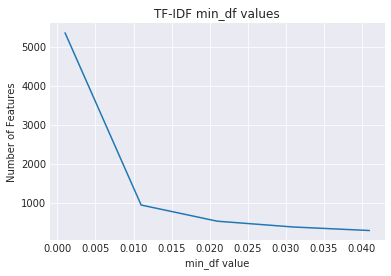

In [14]:
# TF - IDF

count = []
min_df_range = np.arange(0.001, 0.05, 0.01)
for i in min_df_range:
    tf = TfidfVectorizer(stop_words=stop, #ngram_range=(1, 2)
                    token_pattern="\\b[a-z][a-z]+\\b",
                    min_df=i)
    doc_vectors = tf.fit_transform(lemmed_lyrics)
    count.append(len(tf.vocabulary_))
    

plot(min_df_range, count)
title("TF-IDF min_df values")
xlabel('min_df value')
ylabel('Number of Features');

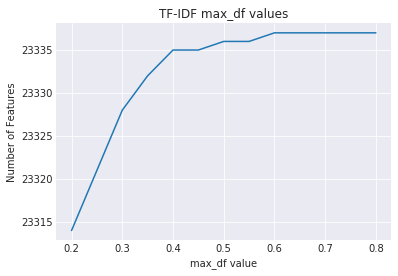

In [15]:
# TF - IDF

count_max = []
max_df_range = np.arange(0.2, 0.8, 0.05)
for i in max_df_range:
    tf = TfidfVectorizer(stop_words=stop, #ngram_range=(1, 2)
                    token_pattern="\\b[a-z][a-z]+\\b",
                    max_df=i)
    doc_vectors = tf.fit_transform(lemmed_lyrics)
    count_max.append(len(tf.vocabulary_))
    

plot(max_df_range, count_max)
title("TF-IDF max_df values")
xlabel('max_df value')
ylabel('Number of Features');

# Entire corpus - all decades

In [35]:
pd.set_option('max_columns', 100)

# Clustering

#### KMeans

In [187]:
# SSEs = []
# Sil_coefs = []
# for k in range(2,30):
#     km = KMeans(n_clusters=k, random_state=1234)
#     km.fit(doc_vectors)
#     labels = km.labels_
#     Sil_coefs.append(metrics.silhouette_score(doc_vectors, labels, metric='euclidean'))
#     SSEs.append(km.inertia_)

In [188]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharex=True)
# k_clusters = range(2,30)
# ax1.plot(k_clusters, Sil_coefs, "bo-")
# ax1.set_xlabel('number of clusters')
# ax1.set_ylabel('silhouette coefficient')

# # plot here on ax2
# ax2.plot(k_clusters, SSEs)
# ax2.set_xlabel('number of clusters')
# ax2.set_ylabel('SSE');

In [36]:
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"', '\\',
         '02', '03', '04', '05', '06', '07',
         '08', '09', '0801', '00', '000', '01',
        '10', '100', '100k', '102', '1020', '105', '106',
        '109', '10th', '11', '110', '112', '113', '118', '11th',
        '12', '120', '129', '12th', '13', '135', '13th', '14', 'Verse',
        'Arrangement', 'Chorus', 'Spoken', 'Outro', 'Intro', 
         '_davy', 'instrumental','num', 'tell', 'hey',
        'know', 'come', 'cause', 'got', 'go', 'see', 'let', 'ay', 
         'na', 'la', 'mo', 'doo', 'da', 'em', 'wit', 'hurts',
        'well', 'ah', 'ha', 'ya', 'uh', 'huh', 'every',
        'oh', 'ooh', 'mmm','get', 'say', 'way', 'talk', 'whoa',
        'still', 'wanna', 'gonna', 'gotta', 'could', 'would', 'gon',
        'mr', 'im', 'ill', 'yes', 'lil', 'really', 'please', 'keep', 
        'need', 'good']
stop = set(stop)

tf = TfidfVectorizer(stop_words=stop, #ngram_range=(1, 2),
                    token_pattern="\\b[a-z][a-z]+\\b",
                    min_df=.011, max_df=0.25)
doc_vectors = tf.fit_transform(lemmed_lyrics)

doc_vectors_back = doc_vectors.toarray()

# TF-IDF Dataframe after some tuning with min_df, n-grams, tokenization
nmf_df = pd.DataFrame(doc_vectors_back, columns=tf.get_feature_names())

In [194]:
# NMF
n_topics = 30
nmf = NMF(n_components=n_topics, 
          random_state=1234,
          alpha=.1,
          l1_ratio=0.5,
          init='random').fit(doc_vectors)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print("Topics for Entire Corpus, All Decades of Music:\n")
print_top_words(nmf, tf.get_feature_names(), 10)
print()
print("Reconstruction Error for %d Topics: %s" % (n_topics, nmf.reconstruction_err_))

Topics for Entire Corpus, All Decades of Music:

Topic #0: boy play new watch promise big front true listen body
Topic #1: think better crazy head might something enough maybe mind woah
Topic #2: show babe name something things prove place gimme goes cannot
Topic #3: little bit thing pretty big sugar old soul closer ride
Topic #4: home alone coming going daddy old call light leave mama
Topic #5: mine fine shine darling kiss mind dear arms find lips
Topic #6: nigga yo niggas shit fuck bitch hot put ass stop
Topic #7: hold kiss tight touch arms darling close hand magic lips
Topic #8: give anything everything chance touch things something live try reason
Topic #9: rock roll beat everybody party body rockin music old soul
Topic #10: money honey buy next throw pay rich hard cash gold
Topic #11: gone long since miss wrong song strong darling head much
Topic #12: us two together apart young stop nobody try strong people
Topic #13: dance music dancing floor move wants chance romance beat every

In [57]:
# Pickle
# with open("nmf_model.pkl", "wb") as f:
#     pickle.dump(nmf, f)

# Open Up NMF Pickle

In [39]:
# #Opening Pickle
# with open("nmf_model.pkl", "rb") as f:
#     nmf = pickle.load(f)

In [40]:
weights = nmf.transform(doc_vectors)

In [41]:
nmf.n_components_

30

In [42]:
# topics_range = range(5, 200)

# reconstruction_scores = []

# for topic in topics_range:
#     nmf = NMF(n_components=topic, 
#        random_state=1234,
#        alpha=.1,
#        l1_ratio=0.5,
#        init='random').fit(doc_vectors)
#     reconstruction_scores.append(nmf.reconstruction_err_)

In [43]:
# plt.plot(topics_range, reconstruction_scores);

In [111]:
doc_max_top = np.argmax(weights, axis=1)
np.bincount(doc_max_top)

array([ 176,  149,  110,  188,  123,  115,  544,  178,  162,  125,   97,
        148,  118,  124,  151,   66,  100,  107,   94,  172,  171,   93,
       1380,  150,  167,  105,  184,  174,  146,  133])

In [112]:
# Visualizing Dominant Topics 

# column names

topicnames = ["Topic" + str(i) for i in range(nmf.n_components_)]

# index names
docnames = ["Doc" + str(i) for i in range(len(lyric_values))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(weights, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val >= .03 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val >= .03 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
#df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)

In [113]:
#pd.set_option("max_columns", 31)
df_document_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,dominant_topic
Doc0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.02,0.0,0.0,0.11,0.0,0.0,0.00,0.00,25
Doc1,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0
Doc2,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.01,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.04,0.0,0.0,0.00,0.0,0.0,0.01,0.01,22
Doc3,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.02,0.0,0.0,0.00,0.0,0.0,0.00,0.03,29
Doc4,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.00,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.01,0.0,0.0,0.00,0.0,0.0,0.00,0.00,13


In [66]:
#df_cleaned_copy['dominant_topic'] = pd.Series(df_document_topic['dominant_topic'].values)

In [67]:
pd.set_option('max_rows', 300)

In [465]:
print()
topic = 23
print("Distribution of Most Dominant Topics Across the Decades: Topic %d" % topic)
df_cleaned[df_cleaned.dominant_topic == topic].groupby('Decade').count()


Distribution of Most Dominant Topics Across the Decades: Topic 23


,position,Song Title,Artist,Year,Lyrics,dominant_topic,Raw Word Count,Unique Word Count,Vocabulary Score,Song And Artist
Decade,,,,,,,,,,
1950,9,9,9,9,9,9,9,9,9,9
1960,16,16,16,16,16,16,16,16,16,16
1970,23,23,23,23,23,23,23,23,23,23
1980,23,23,23,23,23,23,23,23,23,23
1990,34,34,34,34,34,34,34,34,34,34
2000,10,10,10,10,10,10,10,10,10,10
2010,16,16,16,16,16,16,16,16,16,16


In [1]:
# df_cleaned.dominant_topic.value_counts()

###  Plotting Some of the Topics 

In [79]:
df_cleaned['Song And Artist'] = df_cleaned['Artist'] + ": " + df_cleaned['Song Title']


Topic #6: nigga yo niggas shit fuck bitch hot put ass stop


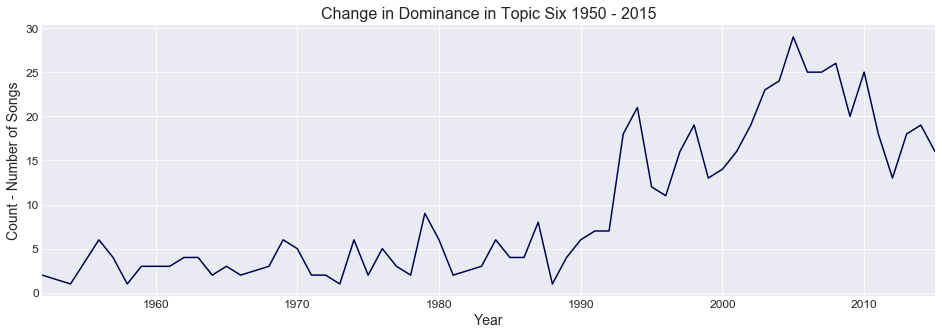

In [170]:
topic_6_years = topic_6_df.groupby("Year")['Song And Artist'].apply(list)
topic_6_years = topic_6_years.reset_index()
topic_6_years['Count'] = pd.Series([len(i) for i in topic_6_years['Song And Artist']])
print("Topic #6: nigga yo niggas shit fuck bitch hot put ass stop")
ax = topic_6_years.plot(x='Year', y='Count', figsize=(16, 5), legend=False,
                  title="Change in Dominance in Topic Six 1950 - 2015", colormap='seismic', fontsize=12)

ax.set_xticklabels(['1950', '1960', '1970', '1980', '1990', '2000', '2010'])
title("Change in Dominance in Topic Six 1950 - 2015", fontsize=16)
xlabel("Year", fontsize=14)
ylabel("Count - Number of Songs", fontsize=14);

In [402]:
topic_6_song_info = ['<br>'.join(topic_6_years['Song And Artist'][index]) for index, element in enumerate(topic_6_years['Song And Artist'])]
year_count = [str(year)+': , '+str(count)+' Songs<br>' for year, count in list(zip(topic_6_years.Year, topic_6_years.Count))]
all_ofit = list(zip(year_count, topic_6_song_info))
topic6_info = [str(i) for i in all_ofit]
topic6_info = [re.sub(r'\"|\'|\(|\)|, ', '', element) for element in topic6_info]
topic6_info = [re.sub(r'\\', '\'', element) for element in topic6_info]

-----

In [57]:
# #Pickle
# with open("topic_6_years.pkl", "wb") as f:
#     pickle.dump(topic_6_years, f)

In [58]:
# #Opening Pickle
# with open("topic_6_years.pkl", "rb") as f:
#     topic_6_years = pickle.load(f)

Topic #7: hold kiss tight touch arms darling close hand magic lips


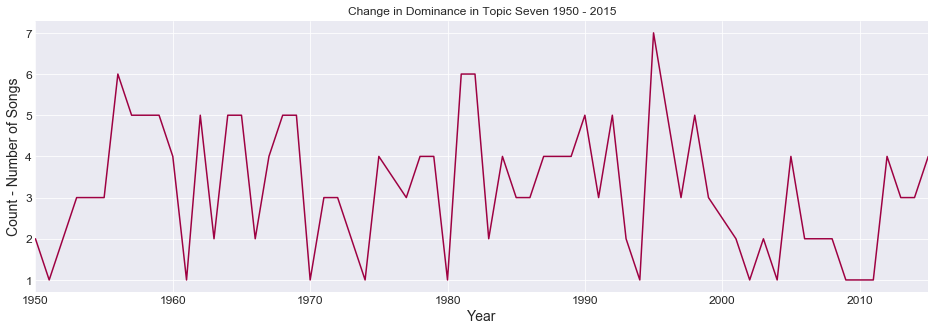

In [171]:
topic_7_years = topic_7_df.groupby("Year")['Song And Artist'].apply(list)
topic_7_years = topic_7_years.reset_index()
topic_7_years['Count'] = pd.Series([len(i) for i in topic_7_years['Song And Artist']])
print("Topic #7: hold kiss tight touch arms darling close hand magic lips")
topic_7_years.plot(x='Year', y='Count', figsize=(16, 5), legend=False,
                  title="Change in Dominance in Topic Seven 1950 - 2015", colormap='Spectral', fontsize=12)

xlabel("Year", fontsize=14)
ylabel("Count - Number of Songs", fontsize=14);

In [404]:
topic_7_song_info = ['<br>'.join(topic_7_years['Song And Artist'][index]) for index, element in enumerate(topic_7_years['Song And Artist'])]
year_count = [str(year)+': , '+str(count)+' Songs<br>' for year, count in list(zip(topic_7_years.Year, topic_7_years.Count))]
all_ofit = list(zip(year_count, topic_7_song_info))
topic7_info = [str(i) for i in all_ofit]
topic7_info = [re.sub(r'\"|\'|\(|\)|, ', '', element) for element in topic7_info]
topic7_info = [re.sub(r'\\', '\'', element) for element in topic7_info]

-----

Topic #13: dance music dancing floor move wants chance romance beat everybody


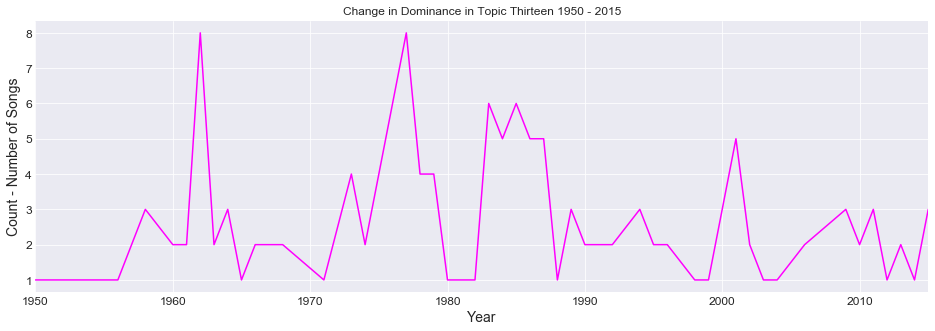

In [180]:
topic_13_years = topic_13_df.groupby("Year")['Song And Artist'].apply(list)
topic_13_years = topic_13_years.reset_index()
topic_13_years['Count'] = pd.Series([len(i) for i in topic_13_years['Song And Artist']])
print("Topic #13: dance music dancing floor move wants chance romance beat everybody")
topic_13_years.plot(x='Year', y='Count', figsize=(16, 5), legend=False,
                  title="Change in Dominance in Topic Thirteen 1950 - 2015", colormap='spring', fontsize=12)

xlabel("Year", fontsize=14)
ylabel("Count - Number of Songs", fontsize=14);

In [408]:
topic_13_song_info = ['<br>'.join(topic_13_years['Song And Artist'][index]) for index, element in enumerate(topic_13_years['Song And Artist'])]
year_count = [str(year)+': , '+str(count)+' Songs<br>' for year, count in list(zip(topic_13_years.Year, topic_13_years.Count))]
all_ofit = list(zip(year_count, topic_13_song_info))
topic13_info = [str(i) for i in all_ofit]
topic13_info = [re.sub(r'\"|\'|\(|\)|, ', '', element) for element in topic13_info]
topic13_info = [re.sub(r'\\', '\'', element) for element in topic13_info]

-----

Topic #19: always forever together true stay darling someone near loving everything


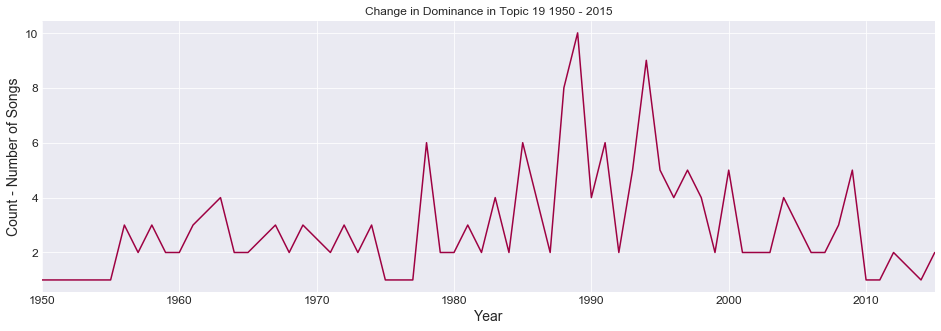

In [212]:
topic_19_df = df_cleaned[df_cleaned.dominant_topic == 19]
topic_19_years = topic_19_df.groupby("Year")['Song And Artist'].apply(list)
topic_19_years = topic_19_years.reset_index()
topic_19_years['Count'] = pd.Series([len(i) for i in topic_19_years['Song And Artist']])
print("Topic #19: always forever together true stay darling someone near loving everything")
topic_19_years.plot(x='Year', y='Count', figsize=(16, 5), legend=False,
                  title="Change in Dominance in Topic 19 1950 - 2015", colormap='Spectral', fontsize=12)

xlabel("Year", fontsize=14)
ylabel("Count - Number of Songs", fontsize=14);

In [411]:
topic_19_song_info = ['<br>'.join(topic_19_years['Song And Artist'][index]) for index, element in enumerate(topic_19_years['Song And Artist'])]
year_count = [str(year)+': , '+str(count)+' Songs<br>' for year, count in list(zip(topic_19_years.Year, topic_19_years.Count))]
all_ofit = list(zip(year_count, topic_19_song_info))
topic19_info = [str(i) for i in all_ofit]
topic19_info = [re.sub(r'\"|\'|\(|\)|, ', '', element) for element in topic19_info]
topic19_info = [re.sub(r'\\', '\'', element) for element in topic19_info]

-----

Topic #25: lonely nights without nobody cry call sad days letter broken


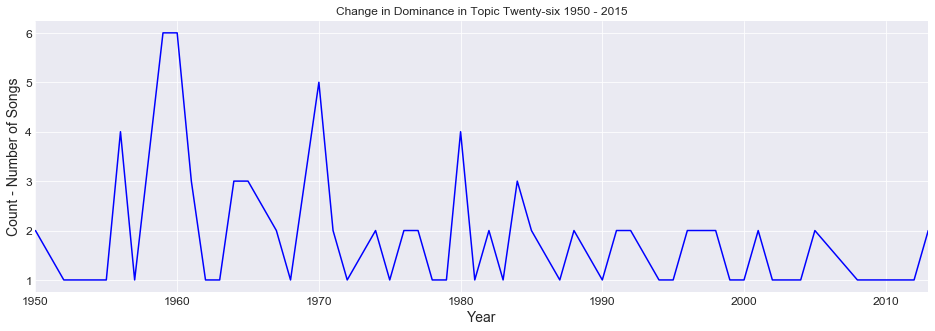

In [455]:
topic_25_df = df_cleaned[df_cleaned.dominant_topic == 25]
topic_25_years = topic_25_df.groupby("Year")['Song And Artist'].apply(list)
topic_25_years = topic_25_years.reset_index()
topic_25_years['Count'] = pd.Series([len(i) for i in topic_25_years['Song And Artist']])
print("Topic #25: lonely nights without nobody cry call sad days letter broken")
topic_25_years.plot(x='Year', y='Count', figsize=(16, 5), legend=False,
                  title="Change in Dominance in Topic Twenty-six 1950 - 2015", colormap='bwr', fontsize=12)

xlabel("Year", fontsize=14)
ylabel("Count - Number of Songs", fontsize=14);

In [456]:
topic_25_song_info = ['<br>'.join(topic_25_years['Song And Artist'][index]) for index, element in enumerate(topic_25_years['Song And Artist'])]
year_count = [str(year)+': , '+str(count)+' Songs<br>' for year, count in list(zip(topic_25_years.Year, topic_25_years.Count))]
all_ofit = list(zip(year_count, topic_25_song_info))
topic25_info = [str(i) for i in all_ofit]
topic25_info = [re.sub(r'\"|\'|\(|\)|, ', '', element) for element in topic25_info]
topic25_info = [re.sub(r'\\', '\'', element) for element in topic25_info]

----

Topic #14: tonight alright light party tomorrow body waiting mind tight everything


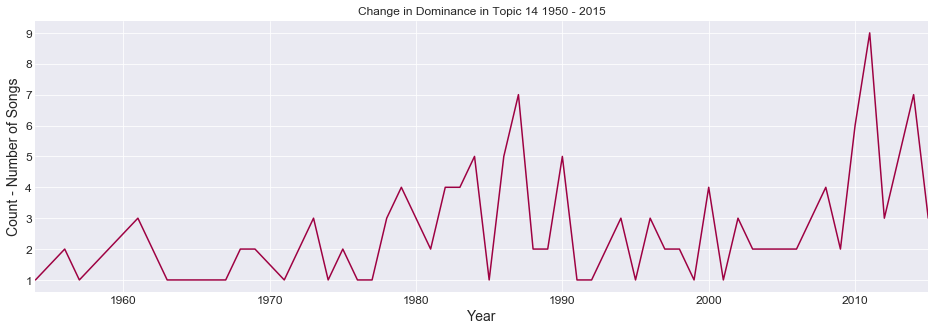

In [214]:
topic_14_df = df_cleaned[df_cleaned.dominant_topic == 14]
topic_14_years = topic_14_df.groupby("Year")['Song And Artist'].apply(list)
topic_14_years = topic_14_years.reset_index()
topic_14_years['Count'] = pd.Series([len(i) for i in topic_14_years['Song And Artist']])
print("Topic #14: tonight alright light party tomorrow body waiting mind tight everything")
topic_14_years.plot(x='Year', y='Count', figsize=(16, 5), legend=False,
                  title="Change in Dominance in Topic 14 1950 - 2015", colormap='Spectral', fontsize=12)

xlabel("Year", fontsize=14)
ylabel("Count - Number of Songs", fontsize=14);

In [419]:
topic_14_song_info = ['<br>'.join(topic_14_years['Song And Artist'][index]) for index, element in enumerate(topic_14_years['Song And Artist'])]
year_count = [str(year)+': , '+str(count)+' Songs<br>' for year, count in list(zip(topic_14_years.Year, topic_14_years.Count))]
all_ofit = list(zip(year_count, topic_14_song_info))
topic14_info = [str(i) for i in all_ofit]
topic14_info = [re.sub(r'\"|\'|\(|\)|, ', '', element) for element in topic14_info]
topic14_info = [re.sub(r'\\', '\'', element) for element in topic14_info]

-----

Topic #10: money honey buy next throw pay rich hard cash gold


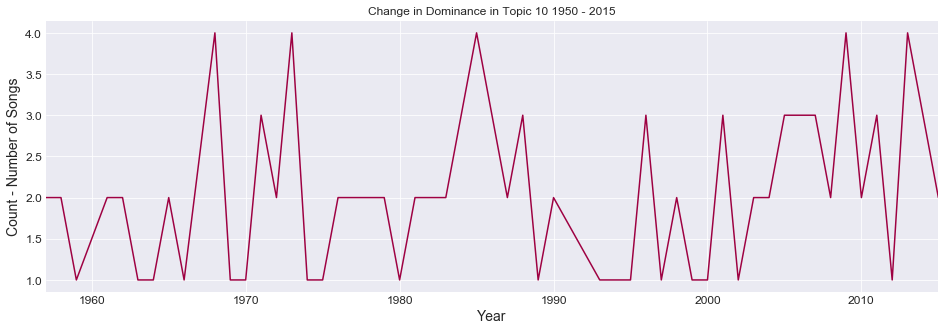

In [215]:
topic_10_df = df_cleaned[df_cleaned.dominant_topic == 10]
topic_10_years = topic_10_df.groupby("Year")['Song And Artist'].apply(list)
topic_10_years = topic_10_years.reset_index()
topic_10_years['Count'] = pd.Series([len(i) for i in topic_10_years['Song And Artist']])
print("Topic #10: money honey buy next throw pay rich hard cash gold")
topic_10_years.plot(x='Year', y='Count', figsize=(16, 5), legend=False,
                  title="Change in Dominance in Topic 10 1950 - 2015", colormap='Spectral', fontsize=12)

xlabel("Year", fontsize=14)
ylabel("Count - Number of Songs", fontsize=14);

In [421]:
topic_10_song_info = ['<br>'.join(topic_10_years['Song And Artist'][index]) for index, element in enumerate(topic_10_years['Song And Artist'])]
year_count = [str(year)+': , '+str(count)+' Songs<br>' for year, count in list(zip(topic_10_years.Year, topic_10_years.Count))]
all_ofit = list(zip(year_count, topic_10_song_info))
topic10_info = [str(i) for i in all_ofit]
topic10_info = [re.sub(r'\"|\'|\(|\)|, ', '', element) for element in topic10_info]
topic10_info = [re.sub(r'\\', '\'', element) for element in topic10_info]

-----

Topic #29: sweet sugar dream honey dreams beautiful thing kind old darling


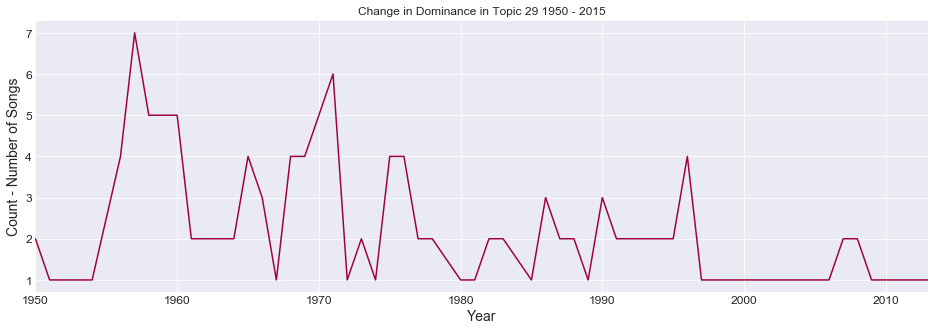

In [228]:
topic_29_df = df_cleaned[df_cleaned.dominant_topic == 29]
topic_29_years = topic_29_df.groupby("Year")['Song And Artist'].apply(list)
topic_29_years = topic_29_years.reset_index()
topic_29_years['Count'] = pd.Series([len(i) for i in topic_29_years['Song And Artist']])
print("Topic #29: sweet sugar dream honey dreams beautiful thing kind old darling")
topic_29_years.plot(x='Year', y='Count', figsize=(16, 5), legend=False,
                  title="Change in Dominance in Topic 29 1950 - 2015", colormap='Spectral', fontsize=12)

xlabel("Year", fontsize=14)
ylabel("Count - Number of Songs", fontsize=14);

In [426]:
topic_29_song_info = ['<br>'.join(topic_29_years['Song And Artist'][index]) for index, element in enumerate(topic_29_years['Song And Artist'])]
year_count = [str(year)+': , '+str(count)+' Songs<br>' for year, count in list(zip(topic_29_years.Year, topic_29_years.Count))]
all_ofit = list(zip(year_count, topic_29_song_info))
topic29_info = [str(i) for i in all_ofit]
topic29_info = [re.sub(r'\"|\'|\(|\)|, ', '', element) for element in topic29_info]
topic29_info = [re.sub(r'\\', '\'', element) for element in topic29_info]

-----

Topic #11: gone long since miss wrong song strong darling head much


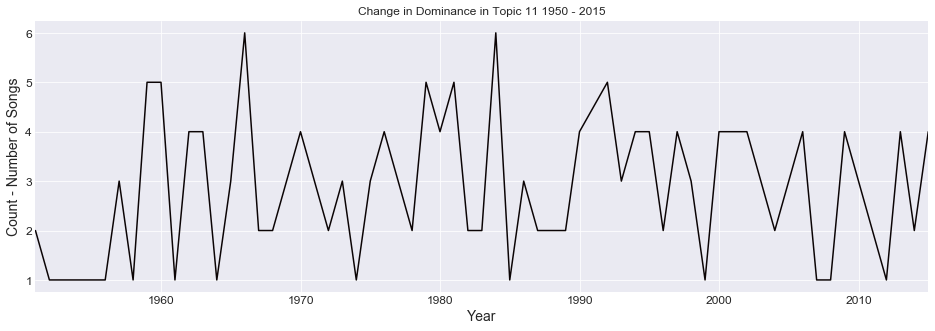

In [233]:
# Breakups and Broken Love

topic_11_df = df_cleaned[df_cleaned.dominant_topic == 11]
topic_11_years = topic_11_df.groupby("Year")['Song And Artist'].apply(list)
topic_11_years = topic_11_years.reset_index()
topic_11_years['Count'] = pd.Series([len(i) for i in topic_11_years['Song And Artist']])
print("Topic #11: gone long since miss wrong song strong darling head much")
topic_11_years.plot(x='Year', y='Count', figsize=(16, 5), legend=False,
                  title="Change in Dominance in Topic 11 1950 - 2015", colormap='mako', fontsize=12)

xlabel("Year", fontsize=14)
ylabel("Count - Number of Songs", fontsize=14);

In [437]:
topic_11_song_info = ['<br>'.join(topic_11_years['Song And Artist'][index]) for index, element in enumerate(topic_11_years['Song And Artist'])]
year_count = [str(year)+': , '+str(count)+' Songs<br>' for year, count in list(zip(topic_11_years.Year, topic_11_years.Count))]
all_ofit = list(zip(year_count, topic_11_song_info))
topic11_info = [str(i) for i in all_ofit]
topic11_info = [re.sub(r'\"|\'|\(|\)|, ', '', element) for element in topic11_info]
topic11_info = [re.sub(r'\\', '\'', element) for element in topic11_info]

-----

Topic #16: give anything everything chance touch things something live try reason


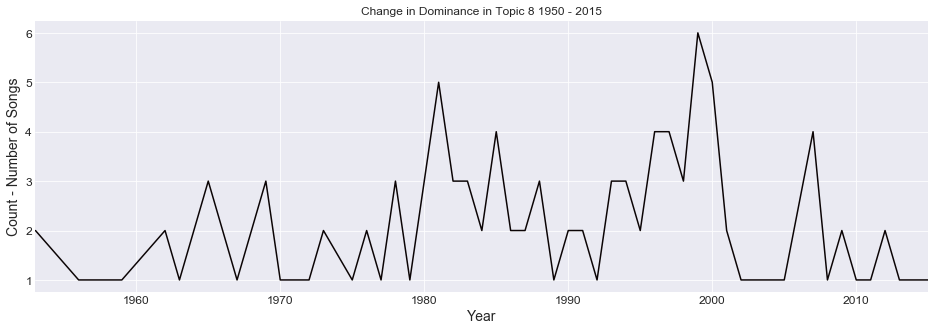

In [459]:
topic_16_df = df_cleaned[df_cleaned.dominant_topic == 16]
topic_16_years = topic_16_df.groupby("Year")['Song And Artist'].apply(list)
topic_16_years = topic_16_years.reset_index()
topic_16_years['Count'] = pd.Series([len(i) for i in topic_16_years['Song And Artist']])
print("Topic #16: give anything everything chance touch things something live try reason")
topic_16_years.plot(x='Year', y='Count', figsize=(16, 5), legend=False,
                  title="Change in Dominance in Topic 8 1950 - 2015", colormap='mako', fontsize=12)

xlabel("Year", fontsize=14)
ylabel("Count - Number of Songs", fontsize=14);

In [460]:
topic_16_song_info = ['<br>'.join(topic_16_years['Song And Artist'][index]) for index, element in enumerate(topic_16_years['Song And Artist'])]
year_count = [str(year)+': , '+str(count)+' Songs<br>' for year, count in list(zip(topic_16_years.Year, topic_16_years.Count))]
all_ofit = list(zip(year_count, topic_16_song_info))
topic16_info = [str(i) for i in all_ofit]
topic16_info = [re.sub(r'\"|\'|\(|\)|, ', '', element) for element in topic16_info]
topic16_info = [re.sub(r'\\', '\'', element) for element in topic16_info]

In [521]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf

plotly.offline.init_notebook_mode(connected=True)

trace_expletives = go.Scatter(x=topic_6_years['Year'],
                        y=topic_6_years['Count'],
                        name='Expletives',
                        line=dict(color='#5E6760'),
                        text=topic6_info,
                        hoverinfo='text')

trace_physical_romance = go.Scatter(x=topic_7_years['Year'],
                            y=topic_7_years['Count'],
                            name='Physical Affection',
                            line=dict(color='#EC1BAD'),
                            text=topic7_info,
                            hoverinfo='text')

#Dancing, dancefloor, boogie, disco, groovy
trace_dancing = go.Scatter(x=topic_13_years['Year'],
                            y=topic_13_years['Count'],
                            name='Dancing',
                            line=dict(color='#FF8B00'),
                            text=topic13_info,
                            hoverinfo='text')

trace_togetherness = go.Scatter(x=topic_19_years['Year'],
                       y=topic_19_years['Count'],
                       name='Togetherness',
                       line=dict(color='#FF0000'),
                       text=topic19_info,
                       hoverinfo='text')

trace_loneliness = go.Scatter(x=topic_25_years['Year'],
                       y=topic_25_years['Count'],
                       name='Loneliness',
                       line=dict(color='#3A18F9'),
                       text=topic25_info,
                       hoverinfo='text')

#Partying, clubbing, drinking, going out 
trace_partying = go.Scatter(x=topic_14_years['Year'],
                       y=topic_14_years['Count'],
                       name='Partying',
                       line=dict(color='#18F8FF'), 
                       text=topic14_info,
                       hoverinfo='text')

trace_money = go.Scatter(x=topic_10_years['Year'],
                       y=topic_10_years['Count'],
                       name='Money',
                       line=dict(color='15B035'),
                       text=topic10_info,
                       hoverinfo='text')

#terms of endearment, sugar, honey 
trace_endearing = go.Scatter(x=topic_29_years['Year'],
                       y=topic_29_years['Count'],
                       name='Endearment',
                       line=dict(color='CAC106'),
                       text=topic29_info,
                       hoverinfo='text')

#Missing a loved one, significant other 
trace_breakups = go.Scatter(x=topic_11_years['Year'],
                       y=topic_11_years['Count'],
                       name='Breakups',
                       line=dict(color='#8418FF'),
                       text=topic11_info,
                       hoverinfo='text')

trace_belief = go.Scatter(x=topic_16_years['Year'],
                       y=topic_16_years['Count'],
                       name='Belief/Dreams',
                       line=dict(color='#00adff'),
                       text=topic16_info,
                       hoverinfo='text')


data = [trace_expletives, trace_physical_romance, trace_dancing,
        trace_togetherness, trace_loneliness, trace_partying,
       trace_money, trace_endearing, 
        trace_breakups, trace_belief]

# Annotations - Permanent Text 

# high_annotations=[dict(x='2016-03-01',
#                        y=df.High.mean(),
#                        xref='x', yref='y',
#                        text='High Average:<br>'+str(df.High.mean()),
#                        ax=0, ay=-40),
#                   dict(x=df.High.idxmax(),
#                        y=df.High.max(),
#                        xref='x', yref='y',
#                        text='High Max:<br>'+str(df.High.max()),
#                        ax=0, ay=-40)]
# low_annotations=[dict(x='2015-05-01',
#                       y=df.Low.mean(),
#                       xref='x', yref='y',
#                       text='Low Average:<br>'+str(df.Low.mean()),
#                       ax=0, ay=40),
#                  dict(x=df.High.idxmin(),
#                       y=df.Low.min(),
#                       xref='x', yref='y',
#                       text='Low Min:<br>'+str(df.Low.min()),
#                       ax=0, ay=40)]

# - Dropdown Menu 

updatemenus = list([
    dict(bgcolor='AAAAAA',
         active = 99,
         bordercolor = '#FFFFFF',
         font = dict(size=11, color='#000000')
    ),
    dict(active=-1,
         buttons=list([             
            dict(label = 'Expletives',
                 method = 'update',
                 args = [{'visible': [True, False, False, False, False, False,
                                     False, False, False, False]},
                         {'title': 'Expletives & Offensive Language'},
                        ]),
             
            dict(label = 'Physical Affection',
                 method = 'update',
                 args = [{'visible': [False, True, False, False, False, False,
                                     False, False, False, False]},
                         {'title': 'Physical Affection'}]),
             
            dict(label = 'Dancing',
                 method = 'update',
                 args = [{'visible': [False, False, True, False, False, False,
                                     False, False, False, False]},
                         {'title': "Dancing & Groovin'"}]),
             
            dict(label = 'Togetherness',
                 method = 'update',
                 args = [{'visible': [False, False, False, True, False, False,
                                     False, False, False, False]},
                         {'title': 'Togetherness'}]),
             
            dict(label = 'Loneliness',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, True, False,
                                     False, False, False, False]},
                         {'title': 'Loneliness'}]),
             
            dict(label = 'Partying',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, True,
                                     False, False, False, False]},
                         {'title': 'Partying & Nightlife'}]),
             
            dict(label = 'Money',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False,
                                     True, False, False, False]},
                         {'title': 'Money'}]),
             
            dict(label = 'Endearment',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False,
                                     False, True, False, False]},
                         {'title': 'Terms of Endearment'}]),
             
            dict(label = 'Breakups',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False,
                                     False, False, True, False]},
                         {'title': 'Breakups & Broken Love'}]),
             
            dict(label = 'Belief/Dreams',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False,
                                     False, False, False, True]},
                         {'title': 'Believing & Dreaming'}]),             
             
            dict(label = 'Reset',
                 method = 'update',
                 args = [{'visible': [True, True, True, True, True, True,
                                     True, True, True, True, True]},
                         {'title': 'Change in Topic Dominance 1950 - 2015'}])
        ]),
    )
])

layout = dict(title='Change in Topic Dominance 1950 - 2015', 
              legend=dict(
                  orientation="v",),        
              updatemenus=updatemenus,
              autosize=True,
              width=1050,
              height=600,
              margin=go.Margin(
                  l=50,
                  r=50,
                  b=100,
                  t=100,
                  pad=4),
            paper_bgcolor='#FFFFFF',
            plot_bgcolor='EDF2F3',      
             xaxis=dict(
             title='Year',
             titlefont=dict(
                 family='Helvetica',
                 size=17,
                 color='#7f7f7f'
             )),
             yaxis=dict(
             title='Number of Songs Per Year',
             titlefont=dict(
                 family='Helvetica',
                 size=17,
                 color='#7f7f7f')))

fig = dict(data=data, layout=layout)
iplot(fig, filename='Topics')

In [2]:
# df_cleaned_copy.groupby(['Decade', 'dominant_topic'])['Song Title'].count().sort_values(ascending=False)

# Topic Modeling on Most Dominant Topic 

Topic #22: world around find mind eyes look nothing cry turn much



In [306]:
topic_22_df = df_cleaned_copy[df_cleaned_copy.dominant_topic == 22]
topic_22_lyrics = topic_22_df.Lyrics.values
lemmed_topic_22 = [lemma.lemmatize(word) for word in topic_22_lyrics]  

In [308]:
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"', '\\',
         '02', '03', '04', '05', '06', '07',
         '08', '09', '0801', '00', '000', '01',
        '10', '100', '100k', '102', '1020', '105', '106',
        '109', '10th', '11', '110', '112', '113', '118', '11th',
        '12', '120', '129', '12th', '13', '135', '13th', '14', 'Verse',
        'Arrangement', 'Chorus', 'Spoken', 'Outro', 'Intro', 
         '_davy', 'instrumental','num', 'tell', 'hey',
        'know', 'come', 'cause', 'got', 'go', 'see', 'let', 'ay', 
         'na', 'la', 'mo', 'doo', 'da', 'em', 'wit', 'hurts',
        'well', 'ah', 'ha', 'ya', 'uh', 'huh', 'every',
        'oh', 'ooh', 'mmm','get', 'say', 'way', 'talk', 'whoa',
        'still', 'wanna', 'gonna', 'gotta', 'could', 'would', 'gon',
        'mr', 'im', 'ill', 'yes', 'lil', 'really', 'please', 'keep', 
        'need', 'good']
stop = set(stop)

tf = TfidfVectorizer(stop_words=stop, #ngram_range=(1, 2),
                    token_pattern="\\b[a-z][a-z]+\\b",
                    min_df=.011, max_df=0.25)
doc_vectors_22 = tf.fit_transform(lemmed_topic_22)

doc_vectors_back = doc_vectors.toarray()

# TF-IDF Dataframe after some tuning with min_df, n-grams, tokenization
nmf_df = pd.DataFrame(doc_vectors_back, columns=tf.get_feature_names())

In [311]:
# NMF
n_topics = 20
nmf = NMF(n_components=n_topics, 
          random_state=1234,
          alpha=.1,
          l1_ratio=0.5,
          init='random').fit(doc_vectors_22)

weights_22 = nmf.transform(doc_vectors_22)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print("Topics for Lyrics within Dominant Topic 22:\n")
print_top_words(nmf, tf.get_feature_names(), 10)
print()
print("Reconstruction Error for %d Topics: %s" % (n_topics, nmf.reconstruction_err_))

Topics for Lyrics within Dominant Topic 22:

Topic #0: try something cut first understand lie everyday step tomorrow doin
Topic #1: girl kind beautiful better needs thing makes wants loving think
Topic #2: new welcome brand town city blow best looking caught moon
Topic #3: fire burn desire smoke burning dark light ring set higher
Topic #4: hear beat running calling body rhythm glad talking meet secrets
Topic #5: everything alright people nothing worry happy talking together going means
Topic #6: song sing land write future along full ring moment songs
Topic #7: fall fools break words birds pieces lovers easy next find
Topic #8: free set everybody fallin easy soul ride born real leave
Topic #9: mind change thinking looking sunshine read blind losing eyes find
Topic #10: world waiting whole change living find perfect place seems people
Topic #11: help heaven falling arms answer called dream living daddy night
Topic #12: turn light follow mean save hurt beat hands darling black
Topic #13:

-----------

In [420]:
# T-SNE
figsize(14, 10)
doc_plot = TSNE(verbose=1, metric='euclidean', init='pca', angle=.99).fit_transform(weights)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5750 samples in 0.097s...
[t-SNE] Computed neighbors for 5750 samples in 1.822s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5750
[t-SNE] Computed conditional probabilities for sample 2000 / 5750
[t-SNE] Computed conditional probabilities for sample 3000 / 5750
[t-SNE] Computed conditional probabilities for sample 4000 / 5750
[t-SNE] Computed conditional probabilities for sample 5000 / 5750
[t-SNE] Computed conditional probabilities for sample 5750 / 5750
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.954018
[t-SNE] Error after 1000 iterations: 1.424102


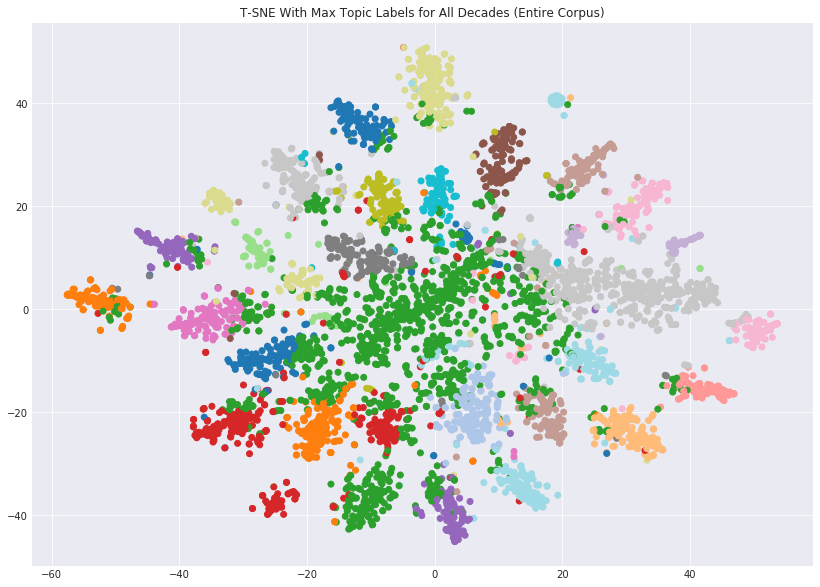

In [421]:
plt.scatter(doc_plot[:,0], doc_plot[:,1], c=doc_max_top, alpha=1, cmap=plt.cm.get_cmap('tab20_r', 30))
plt.title("T-SNE With Max Topic Labels for All Decades (Entire Corpus)");

In [488]:
# just another method
# create 2 dictionaries: words and respective weights

# top_n_words = 10
# t_words, word_strengths = {}, {}
# for t_id, t in enumerate(nmf.components_):
#     t_words[t_id] = [tf.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
#     word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
    
# t_words

# fig, ax = plt.subplots(figsize=(12,18), ncols=3, nrows=10)
# plt.subplots_adjust(
#     wspace  =  0.5,
#     hspace  =  0.5)
# c=0
# for row in range(0,10):
#     for col in range(0,3):
#         sns.barplot(x=word_strengths[c], y=t_words[c], color="b", ax=ax[row][col])
#         c+=1

# 1950s

In [56]:
# Topic Modeling by Decade 

fiftys = df_cleaned_copy[df_cleaned_copy.Decade == '[1950, 1960)']

fiftys_lyrics = fiftys.Lyrics.values

In [57]:
# Stemming fiftys lyrics
stemmed_fiftys = [stemmer.stem(word) for word in fiftys_lyrics]

In [58]:
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"', '\\',
         '02', '03', '04', '05', '06', '07',
         '08', '09', '0801', '00', '000', '01',
        '10', '100', '100k', '102', '1020', '105', '106', 
        '109', '10th', '11', '110', '112', '113', '118', '11th',
        '12', '120', '129', '12th', '13', '135', '13th', '14', 'Verse',
        'Arrangement', 'Chorus', 'Spoken', 'Outro', 'Intro', 
         '_davy', 'instrumental', 'num', 'ee', 'go', 'baby', 'love',
        'girl', 'wanna', 'feel', 'mm', 'mmm', 'heart', 'got', 'gotta']
stop = set(stop)
tf = TfidfVectorizer(stop_words=stop, #ngram_range=(1, 2),
                    token_pattern="\\b[a-z][a-z]+\\b",
                    min_df=.01, max_df=0.45)
doc_vectors_50s = tf.fit_transform(fiftys_lyrics)
doc_vectors_back_50s = doc_vectors_50s.toarray()
pd.DataFrame(doc_vectors_back_50s, columns=tf.get_feature_names())

n_topics = 15
nmf = NMF(n_components=n_topics, random_state=1234, alpha=.1, l1_ratio=0.5, init='random').fit(doc_vectors_50s)
weights = nmf.transform(doc_vectors_50s)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print("Topics for the 1950s:\n")
print_top_words(nmf, tf.get_feature_names(), 10)  

Topics for the 1950s:

Topic #0: yeah uh feeling boy dancing dream sweet lover fool yes
Topic #1: hand walk understand home look dreams afraid stroll said hold
Topic #2: young hey grow grief green great gray grand goodnight goodbye
Topic #3: doll bop along come gal make hair fingers run woman
Topic #4: know yes send like see need lover please answer anyone
Topic #5: oh ah uh tell please sweeter tonight stay little dark
Topic #6: gonna house get find along well come way cause turn
Topic #7: let tight hold bear hop talk stroll lovin tonight take
Topic #8: rock roll dance music clock old two everybody line one
Topic #9: paradise smile angel live near shine like moon life song
Topic #10: never say anyone cry else tender mine wonder darling darlin
Topic #11: like come one true want day mine say please long
Topic #12: young first one johnny look name filled share deep another
Topic #13: ooh cause wait crazy wonder left band ah fall wah
Topic #14: doo dee get da come ah goes cryin whoa heaven

In [59]:
# doc_max_top = np.argmax(doc_vectors_back_50s, axis=1 )

# doc_plot = TSNE(verbose=1, metric='euclidean').fit_transform(doc_vectors_back_50s)
# plt.scatter(doc_plot[:,0], doc_plot[:,1], c=doc_max_top, alpha=.4)
# plt.title("tsne with max topic labels");

In [60]:
# Sentiment Analysis for 50s 
analyzer = SentimentIntensityAnalyzer()
fiftys_sentiments = []
for song in fiftys_lyrics:
    vs = analyzer.polarity_scores(song)
    #print("{:-<65} {}".format(song, str(vs)))
    fiftys_sentiments.append(vs)
    #print("*" * 80)
    
#type(vs)

In [61]:
compound_fiftys = np.mean([song['compound'] for song in fiftys_sentiments])

print("Average Positive Sentiment for 1950s Songs:", np.mean([song['pos'] for song in fiftys_sentiments]))
print("Average Negative Sentiment for 1950s Songs:", np.mean([song['neg'] for song in fiftys_sentiments]))
print("Average Compound Sentiment for 1950s Songs:", compound_fiftys)

Average Positive Sentiment for 1950s Songs: 0.1848827292110874
Average Negative Sentiment for 1950s Songs: 0.06063539445628997
Average Compound Sentiment for 1950s Songs: 0.634592750533049


# 1960s

In [62]:
sixtys = df_cleaned_copy[df_cleaned_copy.Decade == '[1960, 1970)'].reset_index().drop('index', axis=1)

sixtys_lyrics = sixtys.Lyrics.values

In [63]:
# Stemming 60s lyrics
stemmed_sixtys = [stemmer.stem(word) for word in sixtys_lyrics]

In [64]:
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"', '\\',
         '02', '03', '04', '05', '06', '07',
         '08', '09', '0801', '00', '000', '01',
        '10', '100', '100k', '102', '1020', '105', '106',     '109', '10th', '11', '110', '112', '113', '118', '11th',
        '12', '120', '129', '12th', '13', '135', '13th', '14', 'Verse',
        'Arrangement', 'Chorus', 'Spoken', 'Outro', 'Intro', 
         '_davy', 'instrumental', 'num', 'girl', 'oh', 'got', 'get']
stop = set(stop)
tf = TfidfVectorizer(stop_words=stop, #ngram_range=(1, 2),
                    token_pattern="\\b[a-z][a-z]+\\b",
                    min_df=.011)
doc_vectors_60s = tf.fit_transform(sixtys_lyrics)
doc_vectors_back_60s = doc_vectors_60s.toarray()
pd.DataFrame(doc_vectors_back_60s, columns=tf.get_feature_names())

n_topics = 20
nmf = NMF(n_components=n_topics, random_state=1234, alpha=.1, l1_ratio=0.5, init='nndsvd').fit(doc_vectors_60s)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print("Topics for the 1960s:\n")
print_top_words(nmf, tf.get_feature_names(), 10) 

Topics for the 1960s:

Topic #0: love true need always say tell darling heart never way
Topic #1: baby good ya need lovin real wanna want thank yes
Topic #2: know one see never heart say like want way away
Topic #3: la de tonight mean closer friend choose lose cried wonder
Topic #4: yeah whoa gonna gotta know huh good really right one
Topic #5: come back show like tonight please let place together road
Topic #6: none young ground guys guy gun guide guess grows grown
Topic #7: ooh burning hmm wah hang land whoa make anyway always
Topic #8: hey whoa try well said wanna fly made better dig
Topic #9: little bit big world red soul ride like tear feel
Topic #10: blue red boy eyes black pretty world cause heart feelin
Topic #11: go please stay let tell away said must bad leave
Topic #12: man woman born men pretty need give soul soon world
Topic #13: twist shake round work like shout jump well mon come
Topic #14: ah ha cool sugar rain hide keep let goes really
Topic #15: angel like pretty heav

In [65]:
# doc_max_top = np.argmax(doc_vectors_back_60s, axis=1)

# doc_plot = TSNE(verbose=1, metric='euclidean').fit_transform(doc_vectors_back_60s)
# plt.scatter(doc_plot[:,0], doc_plot[:,1], c=doc_max_top, alpha=.4)
# plt.title("tsne with max topic labels");

In [66]:
# Sentiment Analysis for 60s 
analyzer = SentimentIntensityAnalyzer()
sixtys_sentiments = []
for song in sixtys_lyrics:
    vs = analyzer.polarity_scores(song)
    #print("{:-<65} {}".format(song, str(vs)))
    sixtys_sentiments.append(vs)
    #print("*" * 80)

In [67]:
compound_sixtys = np.mean([song['compound'] for song in sixtys_sentiments])

print("Average Positive Sentiment for 1960s Songs:", np.mean([song['pos'] for song in sixtys_sentiments]))
print("Average Negative Sentiment for 1960s Songs:", np.mean([song['neg'] for song in sixtys_sentiments]))
print("Average Compound Sentiment for 1960s Songs:", compound_sixtys)

Average Positive Sentiment for 1960s Songs: 0.18067960088691798
Average Negative Sentiment for 1960s Songs: 0.07149556541019957
Average Compound Sentiment for 1960s Songs: 0.54200066518847


# 1970s

In [68]:
# seventys
seventys = df_cleaned_copy[df_cleaned_copy.Decade == '[1970, 1980)']

seventys_lyrics = seventys.Lyrics.values

stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"', '\\',
         '02', '03', '04', '05', '06', '07',
         '08', '09', '0801', '00', '000', '01',
        '10', '100', '100k', '102', '1020', '105', '106',     '109', '10th', '11', '110', '112', '113', '118', '11th',
        '12', '120', '129', '12th', '13', '135', '13th', '14', 'Verse',
        'Arrangement', 'Chorus', 'Spoken', 'Outro', 'Intro', 
         '_davy', 'instrumental', 'num', 'love', 'know', 'got', 'go',
        'like', 'girl', 'little', 'wanna', 'gonna']
stop = set(stop)
tf = TfidfVectorizer(stop_words=stop, #ngram_range=(1, 2),
                    token_pattern="\\b[a-z][a-z]+\\b",
                    min_df=.011, max_df=0.34)
doc_vectors_70s = tf.fit_transform(seventys_lyrics)
doc_vectors_back_70s = doc_vectors_70s.toarray()
pd.DataFrame(doc_vectors_back_70s, columns=tf.get_feature_names())

n_topics = 20
nmf = NMF(n_components=n_topics, random_state=1234, alpha=.1, l1_ratio=0.5, init='nndsvd').fit(doc_vectors_70s)
weights = nmf.transform(doc_vectors_70s)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print("Topics for the 1970s:\n")
print_top_words(nmf, tf.get_feature_names(), 10)        

Topics for the 1970s:

Topic #0: way never say night one make see right day back
Topic #1: la friends hot line new someday children brand talk mind
Topic #2: baby give feel worry set free lovin nobody hold future
Topic #3: boogie disco round ooo uh doctor huh nights boy ah
Topic #4: ooh heaven ride hoo ho doctor really true lot goodbye
Topic #5: get tonight money made going back around dirty head roll
Topic #6: let give life fall hold grow need show answer live
Topic #7: yeah ah alright tell dancing feeling fire call big kind
Topic #8: dance dancing night ah high music shake beat ground school
Topic #9: want need round see day put somebody around show cryin
Topic #10: man said young home boy call well one born put
Topic #11: come easy better uh darling away dig morning sugar together
Topic #12: song sing play write make blue teach dream hear words
Topic #13: woman evil tryin one beautiful devil hold sweet found ha
Topic #14: ya used door sister better care remember thinkin please great

In [69]:
doc_max_top = np.argmax(weights, axis=1)
np.bincount(doc_max_top)

array([436,  27,  43,  15,  36,  31,  28,  44,  21,  32,  33,  27,  29,
        25,  18,  21,   9,  24,  22,  28])

In [70]:
# # T-SNE
# doc_plot = TSNE(verbose=1, metric='euclidean').fit_transform(weights)
# plt.scatter(doc_plot[:,0], doc_plot[:,1], c=doc_max_top, alpha=.4)
# plt.title("tsne with max topic labels 1970s");

In [71]:
# Sentiment Analysis for 70s 
analyzer = SentimentIntensityAnalyzer()
seventys_sentiments = []
for song in seventys_lyrics:
    vs = analyzer.polarity_scores(song)
    #print("{:-<65} {}".format(song, str(vs)))
    seventys_sentiments.append(vs)
    #print("*" * 80)

In [73]:
compound_seventys = np.mean([song['compound'] for song in seventys_sentiments])
    
print("Average Positive Sentiment for 1970s Songs:", np.mean([song['pos'] for song in seventys_sentiments]))
print("Average Negative Sentiment for 1970s Songs:", np.mean([song['neg'] for song in seventys_sentiments]))
print("Average Compound Sentiment for 1970s Songs:", compound_seventys)

Average Positive Sentiment for 1970s Songs: 0.17375869336143307
Average Negative Sentiment for 1970s Songs: 0.07292413066385671
Average Compound Sentiment for 1970s Songs: 0.5518066385669126


# 1980s

In [74]:
eightys = df_cleaned_copy[df_cleaned_copy.Decade == '[1980, 1990)']
eightys_lyrics = eightys.Lyrics.values

In [75]:
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"', '\\',
         '02', '03', '04', '05', '06', '07',
         '08', '09', '0801', '00', '000', '01',
        '10', '100', '100k', '102', '1020', '105', '106',     '109', '10th', '11', '110', '112', '113', '118', '11th',
        '12', '120', '129', '12th', '13', '135', '13th', '14', 'Verse',
        'Arrangement', 'Chorus', 'Spoken', 'Outro', 'Intro', 
         '_davy', 'instrumental', 'num', 'love', 'lover', 'tell', 'hey',
        'know', 'come', 'cause', 'got', 'go', 'see', 'let', 'heart',
        'well', 'night', 'party', 'music', 'girl', 'little', 'baby', 'babe', 
        'oh', 'ooh', 'mmm', 'girls', 'rock', 'get', 'say', 'way', 'feel', 'talk',
        'still']
stop = set(stop)
tf = TfidfVectorizer(stop_words=stop, #ngram_range=(1, 2),
                    token_pattern="\\b[a-z][a-z]+\\b",
                    min_df=.011, max_df=0.5)
doc_vectors_80s = tf.fit_transform(eightys_lyrics)
doc_vectors_back_80s = doc_vectors_80s.toarray()
pd.DataFrame(doc_vectors_back_80s, columns=tf.get_feature_names())

n_topics = 40
nmf = NMF(n_components=n_topics, random_state=1234, init='nndsvd').fit(doc_vectors_80s)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print("Topics for the 1980s:\n")
print_top_words(nmf, tf.get_feature_names(), 10)  

Topics for the 1980s:

Topic #0: forever together always two hearts us remember ever end every
Topic #1: gonna right nothing make run break body never rhythm somebody
Topic #2: want show money move words enough everything much free someone
Topic #3: yeah everything uh could woman done fine right alright good
Topic #4: wanna feeling touch fun lose really things show ride hide
Topic #5: tonight right light alright angel make stars shine everything save
Topic #6: take home gotta control remember move long town right easy
Topic #7: time much second next fall good every times right better
Topic #8: dance dancing beat wants rhythm days somebody break wall groove
Topic #9: one another would thing ways hearts game two play beat
Topic #10: life waiting dreams live part moment make lady would learned
Topic #11: like walk wind someone step long watch song cut doin
Topic #12: need friend whoa end much really heaven leave believe care
Topic #13: ah ya everything wild big repeat real word really hou

In [76]:
# Sentiment Analysis for 80s 
analyzer = SentimentIntensityAnalyzer()
eightys_sentiments = []
for song in eightys_lyrics:
    vs = analyzer.polarity_scores(song)
    #print("{:-<65} {}".format(song, str(vs)))
    eightys_sentiments.append(vs)
    #print("*" * 80)

In [77]:
compound_eightys = np.mean([song['compound'] for song in eightys_sentiments])

print("Average Positive Sentiment for 1980s Songs:", np.mean([song['pos'] for song in eightys_sentiments]))
print("Average Negative Sentiment for 1980s Songs:", np.mean([song['neg'] for song in eightys_sentiments]))
print("Average Compound Sentiment for 1980s Songs:", compound_eightys)

Average Positive Sentiment for 1980s Songs: 0.1694158110882957
Average Negative Sentiment for 1980s Songs: 0.07812012320328542
Average Compound Sentiment for 1980s Songs: 0.5222445585215606


# 1990s

In [78]:
ninetys = df_cleaned_copy[df_cleaned_copy.Decade == '[1990, 2000)']

In [79]:
ninetys_lyrics = ninetys.Lyrics.values

In [80]:
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"', '\\',
         '02', '03', '04', '05', '06', '07',
         '08', '09', '0801', '00', '000', '01',
        '10', '100', '100k', '102', '1020', '105', '106', '109', 
         '10th', '11', '110', '112', '113', '118', '11th',
        '12', '120', '129', '12th', '13', '135', '13th', '14', 'Verse',
        'Arrangement', 'Chorus', 'Spoken', 'Outro', 'Intro', 
         '_davy', 'instrumental', 'num', 'love', 'lover', 'love', 'girl',
        'wanna', 'tell', 'feel', 'know', 'way', 'could', 'would', 'should', 
        'baby', 'see', 'go', 'get', 'like', 'still', 'say', 'one', 'heart',
        '']
stop = set(stop)
tf = TfidfVectorizer(stop_words=stop, #ngram_range=(1, 2),
                    token_pattern="\\b[a-z][a-z]+\\b",
                    min_df=.02)
doc_vectors_90s = tf.fit_transform(ninetys_lyrics)
doc_vectors_back_90s = doc_vectors_90s.toarray()
pd.DataFrame(doc_vectors_back_90s, columns=tf.get_feature_names())

n_topics = 20
nmf = NMF(n_components=n_topics, random_state=1234, alpha=.1, l1_ratio=0.5, init='nndsvd').fit(doc_vectors_90s)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print("Topics for the 1990s:\n")
print_top_words(nmf, tf.get_feature_names(), 10)  

Topics for the 1990s:

Topic #0: time back take think world away cause day every life
Topic #1: niggas yo nigga shit uh fuck money rock em big
Topic #2: yeah good ooh come thinking time rock mmm dance everybody
Topic #3: want need hold really back kiss right cause close miss
Topic #4: oh ooh touch whoa come need yes hot lady look
Topic #5: got need gotta thinking feeling mind everything getting ooh cause
Topic #6: da la boys comes save men crew somebody matter ah
Topic #7: give anything everything make turn show wants things need body
Topic #8: ya good put need wit daddy better nothin thinkin tryin
Topic #9: gonna tonight make keep body around break away till middle
Topic #10: hey la yo work ha eye play pay come long
Topic #11: ever needed wanted friend need words change dream loved life
Topic #12: never knew keep promise together woman away fall better ooh
Topic #13: without live life someone survive breathe livin anyone everything die
Topic #14: remember used time fell memories days 

In [81]:
# for song in ninetys_lyrics:
#     print(song)
#     print("*"*80)

In [82]:
# Sentiment Analysis for 90s 
analyzer = SentimentIntensityAnalyzer()
ninetys_sentiments = []
for song in ninetys_lyrics:
    vs = analyzer.polarity_scores(song)
    #print("{:-<65} {}".format(song, str(vs)))
    ninetys_sentiments.append(vs)
    #print("*" * 80)

In [83]:
compound_ninetys = np.mean([song['compound'] for song in ninetys_sentiments])

print("Average Positive Sentiment for 1990s Songs:", np.mean([song['pos'] for song in ninetys_sentiments]))
print("Average Negative Sentiment for 1990s Songs:", np.mean([song['neg'] for song in ninetys_sentiments]))
print("Average Compound Sentiment for 1990s Songs:", compound_ninetys)

Average Positive Sentiment for 1990s Songs: 0.16970031545741326
Average Negative Sentiment for 1990s Songs: 0.08014090431125132
Average Compound Sentiment for 1990s Songs: 0.5361288117770768


# 2000s

In [84]:
thousands = df_cleaned_copy[df_cleaned_copy.Decade == '[2000, 2010)']

In [85]:
thousands_lyrics = thousands.Lyrics.values

In [86]:
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"', '\\',
         '02', '03', '04', '05', '06', '07',
         '08', '09', '0801', '00', '000', '01',
        '10', '100', '100k', '102', '1020', '105', '106', '109', 
         '10th', '11', '110', '112', '113', '118', '11th',
        '12', '120', '129', '12th', '13', '135', '13th', '14', 'Verse',
        'Arrangement', 'Chorus', 'Spoken', 'Outro', 'Intro', 
         '_davy', 'instrumental', 'num', 'love', 'lover']
stop = set(stop)
tf = TfidfVectorizer(stop_words=stop, #ngram_range=(1, 2),
                    token_pattern="\\b[a-z][a-z]+\\b",
                    min_df=.011)
doc_vectors_2000 = tf.fit_transform(thousands_lyrics)
doc_vectors_back_2000 = doc_vectors_2000.toarray()
pd.DataFrame(doc_vectors_back_2000, columns=tf.get_feature_names())

n_topics = 20
nmf = NMF(n_components=n_topics, random_state=1234, alpha=.1, l1_ratio=0.5, init='nndsvd').fit(doc_vectors_2000)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print("Topics for the 2000s:\n")
print_top_words(nmf, tf.get_feature_names(), 10)  

Topics for the 2000s:

Topic #0: know never one time life want see like way day
Topic #1: like get got nigga shake yo em hot shit money
Topic #2: oh one alright hey singin slow happy night going late
Topic #3: la mama bump mi boys switch turn losing hey mami
Topic #4: baby know want come babe make need feel thinking like
Topic #5: na hey hustler ay thing cry thong like big hope
Topic #6: go let gone head back sexy wherever get come good
Topic #7: yeah happy mmm tell put game people look really clap
Topic #8: da ba ha loves please whole phone holding thong kiss
Topic #9: uh huh cant head us want mami cool think sexy
Topic #10: ooh woah way wee rock woo shawty bed let trust
Topic #11: say need goodbye name friend course tell please hear well
Topic #12: gonna cha act feelings every remember well wants spending handle
Topic #13: ya let work daddy give see ay bump mi wit
Topic #14: girl man bad tonight girls lookin help mean type wants
Topic #15: away take would pain could walk breath place

In [87]:
# Sentiment Analysis for 90s 
analyzer = SentimentIntensityAnalyzer()
thousands_sentiments = []
for song in thousands_lyrics:
    vs = analyzer.polarity_scores(song)
    #print("{:-<65} {}".format(song, str(vs)))
    thousands_sentiments.append(vs)
    #print("*" * 80)

In [88]:
compound_thousands = np.mean([song['compound'] for song in thousands_sentiments])

print("Average Positive Sentiment for 2000s Songs:", np.mean([song['pos'] for song in thousands_sentiments]))
print("Average Negative Sentiment for 2000s Songs:", np.mean([song['neg'] for song in thousands_sentiments]))
print("Average Compound Sentiment for 2000s Songs:", compound_thousands)

Average Positive Sentiment for 2000s Songs: 0.14918597236981937
Average Negative Sentiment for 2000s Songs: 0.08657385759829969
Average Compound Sentiment for 2000s Songs: 0.4492900106269926


# 2010s

### 2010 - 2015

In [89]:
tens = df_cleaned_copy[df_cleaned_copy.Decade == '[2010, 2016)']

In [90]:
tens_lyrics = tens.Lyrics.values

In [91]:
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"', '\\',
         '02', '03', '04', '05', '06', '07',
         '08', '09', '0801', '00', '000', '01',
        '10', '100', '100k', '102', '1020', '105', '106', '109', 
         '10th', '11', '110', '112', '113', '118', '11th',
        '12', '120', '129', '12th', '13', '135', '13th', '14', 'Verse',
        'Arrangement', 'Chorus', 'Spoken', 'Outro', 'Intro', 
         '_davy', 'instrumental', 'num', 'love', 'lover', 'like', 'baby']
stop = set(stop)
tf = TfidfVectorizer(stop_words=stop, #ngram_range=(1, 2),
                    token_pattern="\\b[a-z][a-z]+\\b",
                    min_df=.011)
doc_vectors_2010 = tf.fit_transform(tens_lyrics)
doc_vectors_back_2010 = doc_vectors_2010.toarray()
pd.DataFrame(doc_vectors_back_2010, columns=tf.get_feature_names())

n_topics = 30
nmf = NMF(n_components=n_topics, random_state=1234, alpha=.1, l1_ratio=0.5, init='nndsvd').fit(doc_vectors_2010)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print("Topics for the 2010s:\n")
print_top_words(nmf, tf.get_feature_names(), 10)  

Topics for the 2010s:

Topic #0: got back way cause right time get one tell make
Topic #1: oh woah hear waiting blow sing see never worry youre
Topic #2: ooh gotta take harder got post watch dancing high scream
Topic #3: la make world da touch feel dark blame push one
Topic #4: hey style mama daddy oooh loving woo find better everybody
Topic #5: nigga bitches fuck niggas bitch money shit got ass bad
Topic #6: na uh nothin ay come name crazy air may melody
Topic #7: girl let look body beats sexy heart learn get babe
Topic #8: gonna deep rolling lose die young break tears night met
Topic #9: tonight holding dj look falling waiting drink let life moment
Topic #10: wanna see wanted honestly words make feel fall wrap rock
Topic #11: go low let starts missing miss hit burning feeling sun
Topic #12: know say lost older gotta wake insane well tell one
Topic #13: dont im youre aint wake ill id cant thats anything
Topic #14: yeah gotta drink da got eyes long feeling riding heaven
Topic #15: ever

In [92]:
# Sentiment Analysis for 90s 
analyzer = SentimentIntensityAnalyzer()
tens_sentiments = []
for song in tens_lyrics:
    vs = analyzer.polarity_scores(song)
    #print("{:-<65} {}".format(song, str(vs)))
    tens_sentiments.append(vs)
    #print("*" * 80)

In [93]:
compound_tens = np.mean([song['compound'] for song in tens_sentiments])

print("Average Positive Sentiment for 2010s Songs:", np.mean([song['pos'] for song in tens_sentiments]))
print("Average Negative Sentiment for 2010s Songs:", np.mean([song['neg'] for song in tens_sentiments]))
print("Average Compound Sentiment for 2010s Songs:", compound_tens)

Average Positive Sentiment for 2010s Songs: 0.15588652482269508
Average Negative Sentiment for 2010s Songs: 0.09395035460992908
Average Compound Sentiment for 2010s Songs: 0.4338432624113475


In [94]:
compound_scores = {"1950s": compound_fiftys, "1960s":compound_sixtys, "1970s":compound_seventys,
                   "1980s":compound_eightys, "1990s":compound_ninetys, "2000s":compound_thousands,
                   "2010s":compound_tens}

In [95]:
compound_scores

{'1950s': 0.634592750533049,
 '1960s': 0.54200066518847,
 '1970s': 0.5518066385669126,
 '1980s': 0.5222445585215606,
 '1990s': 0.5361288117770768,
 '2000s': 0.4492900106269926,
 '2010s': 0.4338432624113475}

In [96]:
df_compound = pd.DataFrame.from_dict(compound_scores, orient='index')

In [97]:
df_compound.reset_index(inplace=True)

In [98]:
df_compound

,index,0
0,1950s,0.634593
1,1960s,0.542001
2,1970s,0.551807
3,1980s,0.522245
4,1990s,0.536129
5,2000s,0.449290
6,2010s,0.433843


In [99]:
df_compound.columns = ['Decade', 'Average Compound Sentiment Score']

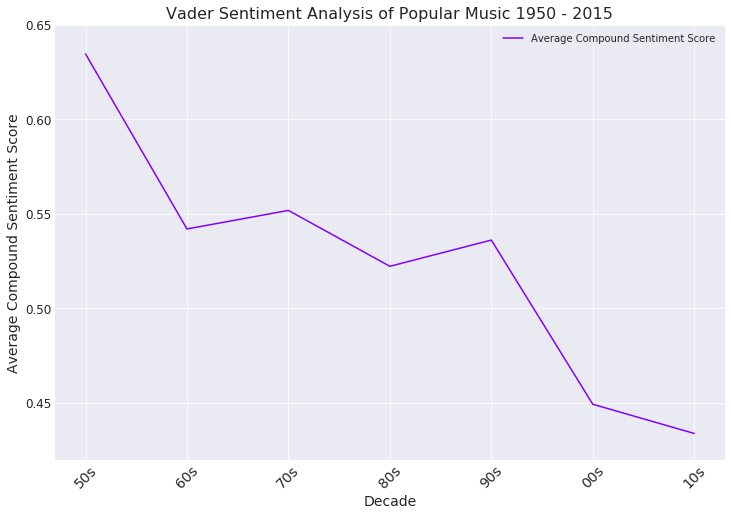

In [107]:
ax = df_compound.plot(figsize=(12,8),
                 ylim=[0.42, 0.65], colormap='rainbow', fontsize=12)

ax.set_xticklabels(["40s", "50s", "60s", '70s', '80s', '90s', '00s', "10s"], rotation=45, fontsize=14)
xlabel("Decade", fontsize=14)
ylabel("Average Compound Sentiment Score", fontsize=14)
plt.title("Vader Sentiment Analysis of Popular Music 1950 - 2015", fontsize=16)
#savefig("vadercompoundanalysis.pdf");

# Word Count and Word Use Analysis

In [119]:
raw_word_counts = []
for idx, row in df_cleaned_copy.Lyrics.iteritems():
    raw_word_counts.append(len(row.split()))

df_cleaned_copy['Raw Word Count'] = pd.Series(raw_word_counts)
df_cleaned_copy['Raw Word Count'].replace(1, np.nan, inplace=True)
df_cleaned_copy['Raw Word Count'].replace(0, np.nan, inplace=True)
df_cleaned_copy['Raw Word Count'].replace(2, np.nan, inplace=True)
df_cleaned_copy['Raw Word Count'].replace(3, np.nan, inplace=True)
df_cleaned_copy['Raw Word Count'].replace(4, np.nan, inplace=True)

In [4]:
# raw_word_avg = df_cleaned.groupby("Year")['Raw Word Count'].mean()

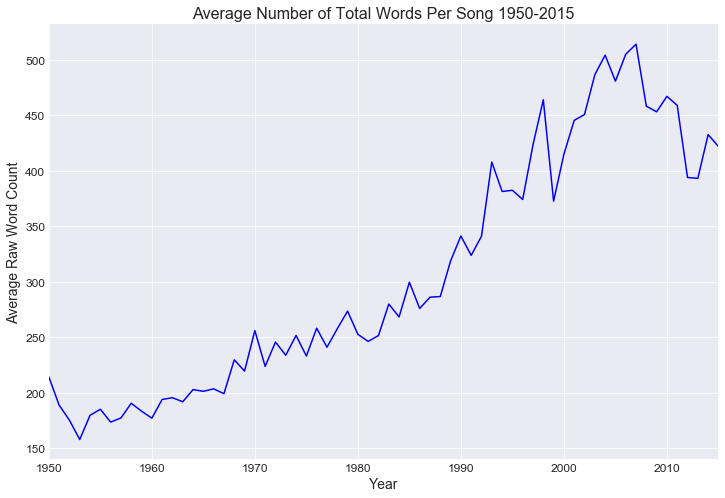

In [506]:
raw_word_avg.plot(figsize=(12, 8), colormap='bwr', fontsize=12)
title("Average Number of Total Words Per Song 1950-2015", fontsize=16)
xlabel("Year", fontsize=14)
ylabel("Average Raw Word Count", fontsize=14);
savefig("raw_words.pdf");

In [131]:
unique_word_counts = []
for idx, row in df_cleaned_copy.Lyrics.iteritems():
    unique_word_counts.append(len(set(row.lower().split())))
    
df_cleaned_copy['Unique Word Count'] = pd.Series(unique_word_counts)
df_cleaned_copy['Unique Word Count'].replace(1, np.nan, inplace=True)
df_cleaned_copy['Unique Word Count'].replace(0, np.nan, inplace=True)
df_cleaned_copy['Unique Word Count'].replace(2, np.nan, inplace=True)

In [509]:
unique_word_avg = df_cleaned.groupby("Year")['Unique Word Count'].mean()

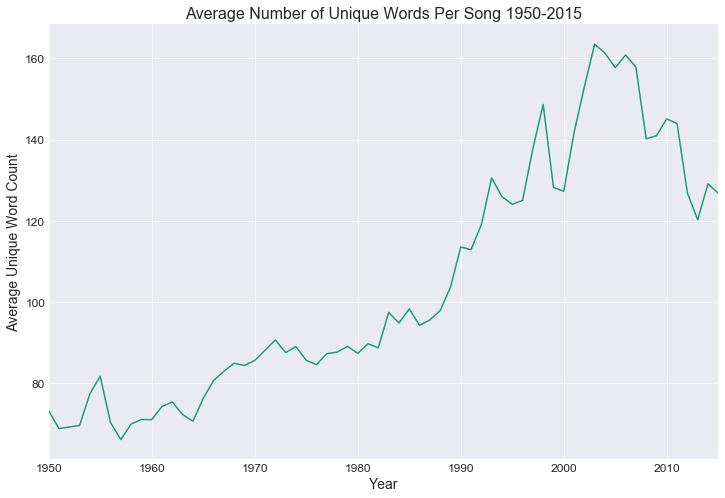

In [513]:
unique_word_avg.plot(figsize=(12, 8), colormap='Dark2', fontsize=12)
title("Average Number of Unique Words Per Song 1950-2015", fontsize=16)
xlabel("Year", fontsize=14)
ylabel("Average Unique Word Count", fontsize=14);
savefig("unique_words.pdf");

In [137]:
# df_cleaned_copy['Vocabulary Score'] = df_cleaned_copy['Unique Word Count'] / df_cleaned_copy['Raw Word Count']

In [144]:
# df_cleaned_copy.drop(['raw_word_count', 'unique_word_count'], axis=1, inplace=True)

In [514]:
decade_vocab_scores = df_cleaned.groupby("Decade")['Vocabulary Score'].mean()
year_vocab_scores = df_cleaned.groupby('Year')['Vocabulary Score'].mean()

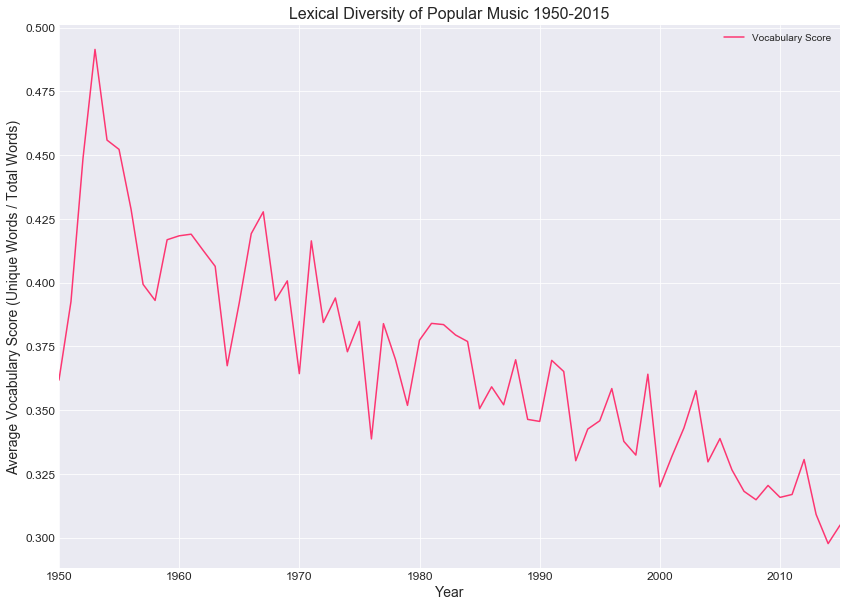

In [519]:
year_vocab_scores.plot(figsize=(14, 10), fontsize=12, color="#FD3672", legend=True)
ylabel("Average Vocabulary Score (Unique Words / Total Words)", fontsize=14)
xlabel("Year", fontsize=14)
title("Lexical Diversity of Popular Music 1950-2015", fontsize=16)
savefig("lexical_diversity.pdf");